# The Battle of Neigborhoods (WEEK 2) : The best place to open an Italian Restaurant in Toronto

## Table of contents
* [Introduction/Business problem](#introduction)
* [Data overview](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction/Business problem<a name="introduction"></a>

This project explores the best location to open an Italian restaurant through the city of Toronto. Toronto, the capital city on the Province of Ontario is the most populous city in Canada. As an important destination for immigrants, it brings in a variety of people from different ethnic. This multicultarism is seen through the various neighbourhoods and the diversity of its food. Furthermore, Toronto is also the fourth largest home to Italians with a population of over 500k. There are then numerous opportunities to open a new Italian restaurant in Toronto.

Opening a restaurant is a lot of commitment and investors need to assess the risk factors before investing. Through this project, I’m going to analyze restaurant venues present in the different neighborhoods of Toronto and predict which location would be most suitable to open an Italian restaurant. Since there are lots of restaurants in Toronto we will try to detect locations that are not already crowded with restaurants and we will also particularly interested in areas with no Italian restaurants in vicinity.

This project is aimed towards Entrepreneurs or Busines owners who plan to invest in the idea of opening an Italien restaurant in Toronto and should help to answer the following question: Where should we open our Italian Restaurant?

## Data overview<a name="data"></a>

We will use a combination of data gathered from Wikipedia, a .csv file and Foursquare API. 
- Wikipedia will provide the names and boroughs of the different neighborhoods in Toronto.
- The Geographical location of these neighbourhoods will be obtained from a csv file.
- Foursquare API will be used to gain information on the above mentioned neighborhoods, specifically the number and quality of Italian restaurants in these neighborhoods. The Venue data will help find which neighbourhood is best suitable to open an Italian restaurant.

### **Toronto Neighborhoods from Wikipedia**

Source : https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

This table will be downloaded, cleaned and transformed into a Pandas data frame

<img src="Toronto_neighborhood.jpg">

### **Geographical location of neighbourhoods**

The csv file giving the coordinates of Toronto's neighborhoods is the one provided week 3 of the course.

<img src="Coordonnees.jpg">

### **Foursquare API**
Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. After finding the list of neighborhoods and their geospatial coordinates, we then connect to the Foursquare API to gather information about venues inside each and every neighborhood. 

The data retrieved from Foursquare API contained information of venues within a specified distance:

- Neighborhood
- Neighborhood Latitude
- Neighborhood Longitude
- Venue
- Name of the venue e.g. the name of a store or restaurant
- Venue Latitude
- Venue Longitude
- Venue Category

## Methodology<a name="methodology"></a>

In [1]:
# import necessary libraries 
!pip install lxml
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

print('Packages installed')

Solving environment: done

# All requested packages already installed.

Packages installed


### Toronto's neighborhoods and coordinates

Let's extract Toronto's neighborhoods from the Wikipedia page into a pandas dataframe

In [2]:
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df=pd.read_html(url)

# Postal code table is the fisrt table on the page
df_toronto=df[0]

df_toronto.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

We will rename columns <strong>Postal Code</strong> and <strong>Neighbourhood</strong>

In [3]:
# Columns renaming
df_toronto.rename(columns={"Postal Code": "PostalCode", "Neighbourhood": "Neighborhood"}, inplace='True')

df_toronto.head()

PostalCode           Borough               Neighborhood
0        M1A      Not assigned               Not assigned
1        M2A      Not assigned               Not assigned
2        M3A        North York                  Parkwoods
3        M4A        North York           Victoria Village
4        M5A  Downtown Toronto  Regent Park, Harbourfront

The cells with <strong>'Not assigned'</strong> values from the Borough column are removed

In [4]:
print("Number of rows in df_toronto: ", len(df_toronto.index))
print("Number of rows with a 'Not assigned' value from the 'Borough'column:",df_toronto.Borough.value_counts()['Not assigned'])

# Dropped cell with Borough that is 'Not assigned' 
df_toronto.drop(df_toronto.index[df_toronto['Borough'] == 'Not assigned'], inplace = True)
df_toronto.reset_index(drop=True, inplace=True)

print("Number of rows in df_toronto after remove: ", len(df_toronto.index))

Number of rows in df_toronto:  180
Number of rows with a 'Not assigned' value from the 'Borough'column: 77
Number of rows in df_toronto after remove:  103


Let's see if there are <strong>'Not assigned'</strong> values in the column Neighborhood and replace them by the same as the Borough

In [5]:
print("Number of 'Not assigned values in column Neighborhood:", len(df_toronto[df_toronto['Neighborhood'] == 'Not assigned']))

Number of 'Not assigned values in column Neighborhood: 0


<p>There are no <em>'Not assigned'</em> values to replace in column 'Neighborhood'</p>

Now we will group Neighborhoods by PostalCode then by Borough and combining Neighborhoods into one raw separated with a comma

In [6]:
df_toronto = df_toronto.groupby(['PostalCode','Borough'])['Neighborhood'].apply(','.join).reset_index()
df_toronto.head(10)

PostalCode      Borough                                     Neighborhood
0        M1B  Scarborough                                   Malvern, Rouge
1        M1C  Scarborough           Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough                Guildwood, Morningside, West Hill
3        M1G  Scarborough                                           Woburn
4        M1H  Scarborough                                        Cedarbrae
5        M1J  Scarborough                              Scarborough Village
6        M1K  Scarborough      Kennedy Park, Ionview, East Birchmount Park
7        M1L  Scarborough                  Golden Mile, Clairlea, Oakridge
8        M1M  Scarborough  Cliffside, Cliffcrest, Scarborough Village West
9        M1N  Scarborough                      Birch Cliff, Cliffside West

We will use the csv file giving the geospatial coordinates of each postal code to obtain the coordinates of each neighborhood.

In [7]:
df_coord= pd.read_csv('Geospatial_Coordinates.csv')

df_coord.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

Let's add latitude and longitude to each postal code in df_table.

In [8]:
# Renaming df_coord column for the join
df_coord.rename(columns = {'Postal Code':'PostalCode'}, inplace = True)

# Merging the dataframes to add logitude and latitude using a left join on df_table
df_toronto = pd.merge(left=df_toronto,right=df_coord, how='left',on='PostalCode')
df_toronto.head(10)

PostalCode      Borough                                     Neighborhood  \
0        M1B  Scarborough                                   Malvern, Rouge   
1        M1C  Scarborough           Rouge Hill, Port Union, Highland Creek   
2        M1E  Scarborough                Guildwood, Morningside, West Hill   
3        M1G  Scarborough                                           Woburn   
4        M1H  Scarborough                                        Cedarbrae   
5        M1J  Scarborough                              Scarborough Village   
6        M1K  Scarborough      Kennedy Park, Ionview, East Birchmount Park   
7        M1L  Scarborough                  Golden Mile, Clairlea, Oakridge   
8        M1M  Scarborough  Cliffside, Cliffcrest, Scarborough Village West   
9        M1N  Scarborough                      Birch Cliff, Cliffside West   

    Latitude  Longitude  
0  43.806686 -79.194353  
1  43.784535 -79.160497  
2  43.763573 -79.188711  
3  43.770992 -79.216917  
4  43.773136 -79.239476  
5  43.744734 -79.239476  
6  43.727929 -79.262029  
7  43.711112 -79.284577  
8  43.716316 -79.239476  
9  43.692657 -79.264848

Now that we have all Toronto's neighborhoods and their coordinates we can create a map of Toronto with neighborhoods superimposed on top.

In [9]:
#Use geopy library to get the latitude and longitude values of Toronto City
address = 'Toronto, Ontario'

# Define a user_agent names "toronto_explorer" to create an instance of the geocoder
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('\n The geograpical coordinate of Toronto are {}, {}.\n'.format(latitude, longitude))


# Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


 The geograpical coordinate of Toronto are 43.6534817, -79.3839347.



### Foursquare API

Next we will define Foursquare Credentials and Version (*credentials have been changed for the privacy*) 

In [60]:
CLIENT_ID = 'MYID'      
CLIENT_SECRET = 'MYSECRET'   
VERSION = '20180901'

The function *getNearbyVenues* will be used to explore venues for each neighborhood

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's get the top 100 venues for each neighborhood within a radius of 500 meters.

In [12]:
radius = 500
LIMIT = 100 

ct_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'],
                                   radius = radius,
                                   LIMIT = LIMIT
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [13]:
print(ct_venues.shape)
ct_venues.head()

(2139, 7)


Neighborhood  Neighborhood Latitude  \
0                          Malvern, Rouge              43.806686   
1  Rouge Hill, Port Union, Highland Creek              43.784535   
2  Rouge Hill, Port Union, Highland Creek              43.784535   
3       Guildwood, Morningside, West Hill              43.763573   
4       Guildwood, Morningside, West Hill              43.763573   

   Neighborhood Longitude                                              Venue  \
0              -79.194353                                            Wendy’s   
1              -79.160497                              Royal Canadian Legion   
2              -79.160497  SEBS Engineering Inc. (Sustainable Energy and ...   
3              -79.188711                                     RBC Royal Bank   
4              -79.188711                                  G & G Electronics   

   Venue Latitude  Venue Longitude              Venue Category  
0       43.807448       -79.199056        Fast Food Restaurant  
1       43.782533       -79.163085                         Bar  
2       43.782371       -79.156820  Construction & Landscaping  
3       43.766790       -79.191151                        Bank  
4       43.765309       -79.191537           Electronics Store

There are total 2139 of venues in the neighborhoods of our dataset.      
Let's check how many venues were returned for each neighborhood

In [14]:
ct_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               5   
Alderwood, Long Branch                                                  7   
Bathurst Manor, Wilson Heights, Downsview North                        21   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      22   
Berczy Park                                                            55   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           23   
Business reply mail Processing Centre, South Ce...                     16   
CN Tower, King and Spadina, Railway Lands, Harb...                     16   
Caledonia-Fairbanks                                                     4   
Canada Post Gateway Processing Centre                                  13   
Cedarbrae                                                               8   
Central Bay Street                                                     68   
Christie                                                               16   
Church and Wellesley                                                   75   
Clarks Corners, Tam O'Shanter, Sullivan                                12   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             33   
Davisville North                                                        9   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        5   
Don Mills                                                              23   
Dorset Park, Wexford Heights, Scarborough Town ...                      5   
Downsview                                                              16   
Dufferin, Dovercourt Village                                           13   
East Toronto, Broadview North (Old East York)                           3   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      8   
Fairview, Henry Farm, Oriole                                           70   
First Canadian Place, Underground city                                100   
Forest Hill North & West, Forest Hill Road Park                         4   
Garden District, Ryerson                                              100   
Glencairn                                                               5   
Golden Mile, Clairlea, Oakridge                                        10   
Guildwood, Morningside, West Hill                                       8   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          25   
Hillcrest Village                                                       5   
Humber Summit                                                           2   
Humberlea, Emery                                                        1   
Humewood-Cedarvale                                                      5   
India Bazaar, The Beaches West                                         19   
Kennedy Park, Ionview, East Birchmount Park                             4   
Kensington Market, Chinatown, Grange Park                              74   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                                       13   
Lawrence Park                                                           3   
Leaside                                                                33   
Little Portugal, Trinity                                               45   
Malvern, Rouge                                                          1   
Milliken, Agincourt North, Steeles East, L'Amor.

And how many unique venues are there?


In [15]:
print('There are {} uniques categories.'.format(len(ct_venues['Venue Category'].unique())))

There are 273 uniques categories.


In [16]:
print("The Venue Categories are\n", ct_venues['Venue Category'].unique())

The Venue Categories are
 ['Fast Food Restaurant' 'Bar' 'Construction & Landscaping' 'Bank'
 'Electronics Store' 'Restaurant' 'Mexican Restaurant'
 'Rental Car Location' 'Medical Center' 'Intersection' 'Breakfast Spot'
 'Coffee Shop' 'Korean BBQ Restaurant' 'Hakka Restaurant'
 'Caribbean Restaurant' 'Thai Restaurant' 'Athletics & Sports'
 'Gas Station' 'Bakery' 'Fried Chicken Joint' 'Playground' 'Jewelry Store'
 'Smoke Shop' 'Department Store' 'Hobby Shop' 'Train Station'
 'Ice Cream Shop' 'Bus Line' 'Metro Station' 'Bus Station' 'Park'
 'Soccer Field' 'Motel' 'American Restaurant' 'Café'
 'General Entertainment' 'Skating Rink' 'College Stadium'
 'Chinese Restaurant' 'Vietnamese Restaurant' 'Indian Restaurant'
 'Pet Store' 'Sandwich Place' 'Middle Eastern Restaurant' 'Auto Garage'
 'Accessories Store' 'Latin American Restaurant' 'Lounge' 'Clothing Store'
 'Italian Restaurant' 'Noodle House' 'Pizza Place' 'Pharmacy'
 'Grocery Store' 'Gym' 'Golf Course' 'Pool' 'Mediterranean Restaurant'


Let's see how many "Italian Restaurant" are they in these venues ?

In [17]:
ct_venues[ct_venues['Venue Category']=='Italian Restaurant'].count()

Neighborhood              38
Neighborhood Latitude     38
Neighborhood Longitude    38
Venue                     38
Venue Latitude            38
Venue Longitude           38
Venue Category            38
dtype: int64

There are 38 Italian Restaurants

#### Analyze each neighborhood


We first need to convert the venue categories in one-hot vector form such that if a venue category occurs in a particular neighborhood, we assign 1 to it's corresponding category and 0 where it doesn't occur.


In [18]:
# one hot encoding
ct_onehot = pd.get_dummies(ct_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ct_onehot['Neighborhood'] = ct_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ct_onehot.columns[-1]] + list(ct_onehot.columns[:-1])
mct_onehot = ct_onehot[fixed_columns]

Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [19]:

ct_grouped = ct_onehot.groupby(["Neighborhood"]).mean().reset_index()

print(ct_grouped.shape)
ct_grouped.head()

(96, 273)


Neighborhood  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                0.0      0.0                 0.0           0.0   
1                0.0      0.0                 0.0           0.0   
2                0.0      0.0                 0.0           0.0   
3                0.0      0.0                 0.0           0.0   
4                0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.000000   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.000000   
4             0.0              0.0               0.0             0.045455   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0           0.0       0.0          0.0         0.0                  0.0   
1           0.0       0.0          0.0         0.0                  0.0   
2           0.0       0.0          0.0         0.0                  0.0   
3           0.0       0.0          0.0         0.0                  0.0   
4           0.0       0.0          0.0         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  \
0               0.0                 0.0          0.0            0.0   
1               0.0                 0.0          0.0            0.0   
2               0.0                 0.0          0.0            0.0   
3               0.0                 0.0          0.0            0.0   
4               0.0                 0.0          0.0            0.0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery      Bank  Bar  Baseball Field  \
0        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   
1        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   
2        0.0         0.0         0.0     0.0  0.095238  0.0             0.0   
3        0.0         0.0         0.0     0.0  0.250000  0.0             0.0   
4        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   

   Baseball Stadium  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Boat or Ferry  \
0         0.0                 0.0        0.0     0.0            0.0   
1         0.0                 0.0        0.0     0.0            0.0   
2         0.0                 0.0        0.0     0.0            0.0   
3         0.0                 0.0        0.0     0.0            0.0   
4         0.0                 0.0        0.0     0.0            0.0   

   Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  \
0        0.0       0.0                   0.0             0.2      0.0   
1        0.0       0.0                   0.0             0.0      0.0   
2        0.0       0.0                   0.0             0.0      0.0   
3        0.0       0.0                   0.0             0.0      0.0   
4        0.0       0.0                   0.0             0.0      0.0   

   Bridal Shop  Bubble Tea Shop  Building  Burger J

Mean frequency obtained for Italian Restaurants

In [20]:
italian = ct_grouped[["Neighborhood","Italian Restaurant"]]
italian.head(5)

Neighborhood  Italian Restaurant
0                                        Agincourt            0.000000
1                           Alderwood, Long Branch            0.000000
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000
3                                  Bayview Village            0.000000
4                Bedford Park, Lawrence Manor East            0.090909

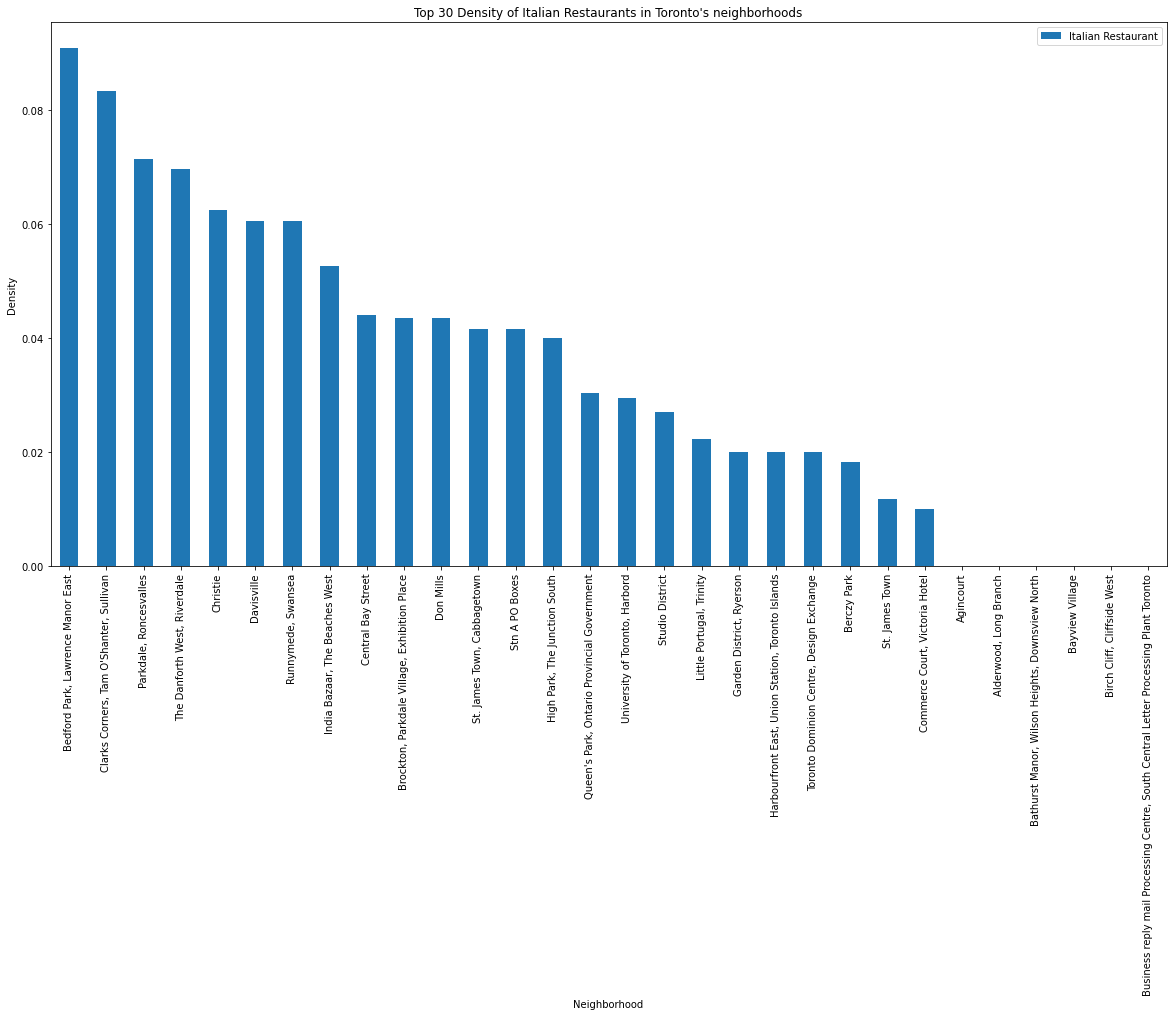

In [21]:
italian.nlargest(30,'Italian Restaurant').plot(kind='bar',x='Neighborhood',y='Italian Restaurant', figsize=(20,10))
plt.xlabel('Neighborhood') 
plt.ylabel('Density') 
plt.title("Top 30 Density of Italian Restaurants in Toronto's neighborhoods")

plt.show()

### Clustering neighborhoods

Now we will use the k-means model to cluster neighborhoods and use the <strong>Elbow Point method</strong> to find the best number of clusters k.

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=15, random_state=8)
X = italian.drop(['Neighborhood'], axis=1)

In [23]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0], dtype=int32)

In [24]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [25]:
scores = [get_inertia(x) for x in range(2,10)]

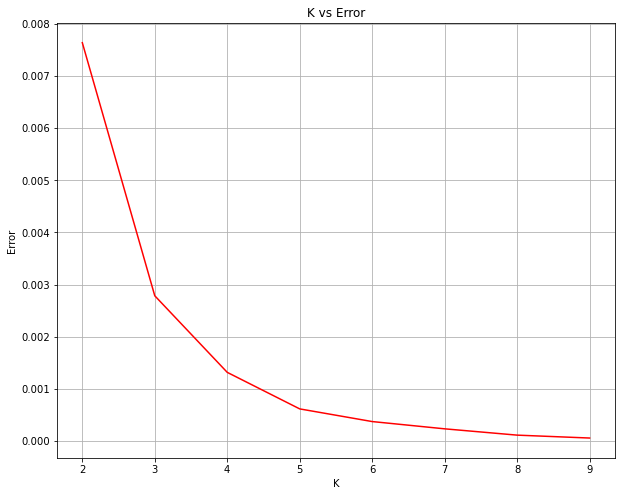

In [26]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 10), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 10))
plt.xlabel("K")
plt.ylabel("Error")
plt.grid()
plt.show()

As we can see in the plot below, according the elbow method the best K is 4.

In [46]:
# set number of clusters
kclusters = 4

ct_grouped_clustering = ct_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ct_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe <em>ct_merged</em> that includes the neighborhoods, their coordinates, the venues and their clusters

In [47]:
# Copy df_boroughs in ct_merged
ct_merged = italian.copy()

# Add clustering labels
ct_merged['Cluster Labels'] = kmeans.labels_

# Merge ct_merged with neighborhoods_venues_sorted
ct_merged = ct_merged.join(ct_venues.set_index('Neighborhood'), on='Neighborhood')

ct_merged.head(10)

Neighborhood  Italian Restaurant  Cluster Labels  \
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
1              43.602414              -79.543484   
1              43.602414              -79.543484   
1              43.602414              -79.543484   
1              43.602414              -79.543484   
1              43.602414              -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                     El Pulgarcito       43.792648       -79.259208   
0                          Twilight       43.791999       -79.258584   
0                            Mark's       43.791179       -79.259714   
0                   Commander Arena       43.794867       -79.267989   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   
1                     Timothy's Pub       43.600165       -79.544699   
1  Toronto Gymnastics International       43.599832       -79.542924   
1                       Tim Hortons       43.602396       -79.545048   
1                       Pizza Pizza       43.605340       -79.547252   

              Venue Category  
0             Breakfast Spot  
0  Latin American Restaurant  
0                     Lounge  
0             Clothing Store  
0               Skating Rink  
1                Pizza Place  
1                        Pub  
1                        Gym  
1                Coffee Shop  
1                Pizza Place

In [48]:
# sort the results by Cluster Labels
print(ct_merged.shape)
ct_merged.sort_values(["Cluster Labels"], inplace=True)

(2139, 9)


Let's visualize the clustering with Folium

In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        ct_merged['Neighborhood Latitude'], 
        ct_merged['Neighborhood Longitude'], 
        ct_merged['Neighborhood'], 
        ct_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

Let's see how many neighborhooods we have per cluster

In [50]:
italian["Cluster Labels"] = kmeans.labels_
italian['Cluster Labels'].value_counts()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    83
3    10
1     2
2     1
Name: Cluster Labels, dtype: int64

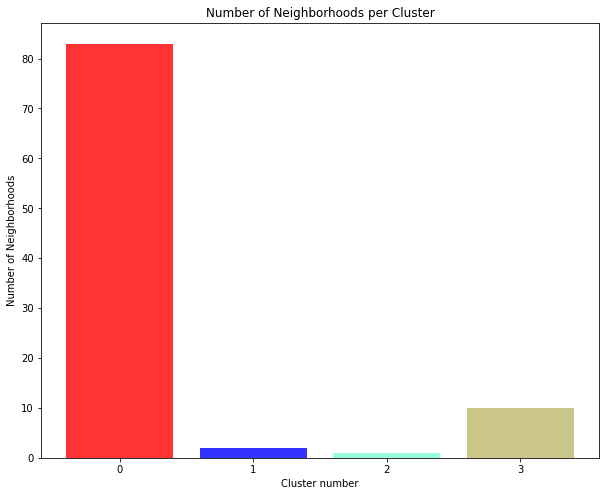

In [51]:
objects = (0,1,2,3)
y_pos = np.arange(len(objects))
performance = italian['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.figure(figsize=[10, 8])
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'blue','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Cluster number')
plt.title('Number of Neighborhoods per Cluster')

plt.show()

### Examining each cluster

<strong>Cluster 0</strong>

In [58]:
# Red 
df_borough=df_toronto[['Borough', 'Neighborhood']]
cluster0 = ct_merged.loc[ct_merged['Cluster Labels'] == 0]
df_cluster0 = pd.merge(df_borough, cluster0, on='Neighborhood')
df_cluster0

Borough                                       Neighborhood  \
0          Scarborough             Rouge Hill, Port Union, Highland Creek   
1          Scarborough             Rouge Hill, Port Union, Highland Creek   
2          Scarborough                  Guildwood, Morningside, West Hill   
3          Scarborough                  Guildwood, Morningside, West Hill   
4          Scarborough                  Guildwood, Morningside, West Hill   
5          Scarborough                  Guildwood, Morningside, West Hill   
6          Scarborough                  Guildwood, Morningside, West Hill   
7          Scarborough                  Guildwood, Morningside, West Hill   
8          Scarborough                  Guildwood, Morningside, West Hill   
9          Scarborough                  Guildwood, Morningside, West Hill   
10         Scarborough                                             Woburn   
11         Scarborough                                             Woburn   
12         Scarborough                                             Woburn   
13         Scarborough                                             Woburn   
14         Scarborough                                          Cedarbrae   
15         Scarborough                                          Cedarbrae   
16         Scarborough                                          Cedarbrae   
17         Scarborough                                          Cedarbrae   
18         Scarborough                                          Cedarbrae   
19         Scarborough                                          Cedarbrae   
20         Scarborough                                          Cedarbrae   
21         Scarborough                                          Cedarbrae   
22         Scarborough                                Scarborough Village   
23         Scarborough                                Scarborough Village   
24         Scarborough                                Scarborough Village   
25         Scarborough        Kennedy Park, Ionview, East Birchmount Park   
26         Scarborough        Kennedy Park, Ionview, East Birchmount Park   
27         Scarborough        Kennedy Park, Ionview, East Birchmount Park   
28         Scarborough        Kennedy Park, Ionview, East Birchmount Park   
29         Scarborough                    Golden Mile, Clairlea, Oakridge   
30         Scarborough                    Golden Mile, Clairlea, Oakridge   
31         Scarborough                    Golden Mile, Clairlea, Oakridge   
32         Scarborough                    Golden Mile, Clairlea, Oakridge   
33         Scarborough                    Golden Mile, Clairlea, Oakridge   
34         Scarborough                    Golden Mile, Clairlea, Oakridge   
35         Scarborough                    Golden Mile, Clairlea, Oakridge   
36         Scarborough                    Golden Mile, Clairlea, Oakridge   
37         Scarborough                    Golden Mile, Clairlea, Oakridge   
38         Scarborough                    Golden Mile, Clairlea, Oakridge   
39         Scarborough    Cliffside, Cliffcrest, Scarborough Village West   
40         Scarborough    Cliffside, Cliffcrest, Scarborough Village West   
41         Scarborough                        Birch Cliff, Cliffside West   
42         Scarborough                        Birch Cliff, Cliffside West   
43         Scarborough                        Birch Cliff, Cliffside West   
44         Scarborough                        Birch Cliff, Cliffside West   
45         Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
46         Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
47         Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
48         Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
49         Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
50         Scarborough                                  Wexford, Maryvale   
51         

<strong>Cluster 1</strong>

In [53]:
# Blue
cluster1 = ct_merged.loc[ct_merged['Cluster Labels'] == 1]
df_cluster1 = pd.merge(df_borough, cluster1, on='Neighborhood')
df_cluster1.head(15)

Borough                                       Neighborhood  \
0   Etobicoke  Old Mill South, King's Mill Park, Sunnylea, Hu...   
1   Etobicoke  Old Mill South, King's Mill Park, Sunnylea, Hu...   
2  North York                                   Humberlea, Emery   

   Italian Restaurant  Cluster Labels  Neighborhood Latitude  \
0                 0.0               1              43.636258   
1                 0.0               1              43.636258   
2                 0.0               1              43.724766   

   Neighborhood Longitude             Venue  Venue Latitude  Venue Longitude  \
0              -79.498509     Woodford Park       43.633152       -79.496266   
1              -79.498509  Tornado Plumbing       43.635516       -79.492757   
2              -79.532242   Strathburn Park       43.721765       -79.532854   

               Venue Category  
0              Baseball Field  
1  Construction & Landscaping  
2              Baseball Field

<strong>Cluster 2</strong>

In [35]:
# Aquamarine
cluster2 = ct_merged.loc[ct_merged['Cluster Labels'] == 2]
df_cluster2 = pd.merge(df_borough, cluster2, on='Neighborhood')
df_cluster2.head(15)

Borough    Neighborhood  Italian Restaurant  Cluster Labels  \
0  Scarborough  Malvern, Rouge                 0.0               2   

   Neighborhood Latitude  Neighborhood Longitude    Venue  Venue Latitude  \
0              43.806686              -79.194353  Wendy’s       43.807448   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant

<strong>Cluster 3</strong>

In [36]:
# Darkkhaki
cluster3 = ct_merged.loc[ct_merged['Cluster Labels'] == 3]
df_cluster3 = pd.merge(df_borough, cluster3, on='Neighborhood')
df_cluster3.head(15)

Borough                                       Neighborhood  \
0        Scarborough  Milliken, Agincourt North, Steeles East, L'Amo...   
1        Scarborough  Milliken, Agincourt North, Steeles East, L'Amo...   
2        Scarborough  Milliken, Agincourt North, Steeles East, L'Amo...   
3         North York                                    York Mills West   
4         North York                                    York Mills West   
5         North York                                          Parkwoods   
6         North York                                          Parkwoods   
7          East York      East Toronto, Broadview North (Old East York)   
8          East York      East Toronto, Broadview North (Old East York)   
9          East York      East Toronto, Broadview North (Old East York)   
10   Central Toronto                                      Lawrence Park   
11   Central Toronto                                      Lawrence Park   
12   Central Toronto                                      Lawrence Park   
13  Downtown Toronto                                           Rosedale   
14  Downtown Toronto                                           Rosedale   

    Italian Restaurant  Cluster Labels  Neighborhood Latitude  \
0                  0.0               3              43.815252   
1                  0.0               3              43.815252   
2                  0.0               3              43.815252   
3                  0.0               3              43.752758   
4                  0.0               3              43.752758   
5                  0.0               3              43.753259   
6                  0.0               3              43.753259   
7                  0.0               3              43.685347   
8                  0.0               3              43.685347   
9                  0.0               3              43.685347   
10                 0.0               3              43.728020   
11                 0.0               3              43.728020   
12                 0.0               3              43.728020   
13                 0.0               3              43.679563   
14                 0.0               3              43.679563   

    Neighborhood Longitude                              Venue  Venue Latitude  \
0               -79.284577                  Queen Pastisserie       43.815492   
1               -79.284577  Milliken Public School Playground       43.815383   
2               -79.284577                    Port Royal Park       43.815477   
3               -79.400049                  Kitchen Food Fair       43.751298   
4               -79.400049                    Tournament Park       43.751257   
5               -79.329656                      Variety Store       43.751974   
6               -79.329656                    Brookbanks Park       43.751976   
7               -79.338106                 Sammon Convenience       43.686951   
8               -79.338106                           The Path       43.683923   
9               -79.338106                   Danforth & Jones       43.684352   
10              -79.388790                 Zodiac Swim School       43.728532   
11              -79.388790     TTC Bus #162 - Lawrence-Donway       43.728026   
12              -79.388790               Lawrence Park Ravine       43.726963   
13              -79.377529                     Milkman's Lane       43.676352   
14              -79.377529               Alex Murray Parkette       43.678300   

    Venue Longitude     Venue Category  
0        -79.289715             Bakery  
1        -79.289867         Playground  
2        -79.289773               Park  
3        -79.401393  Convenience Store  
4        -79.399717               Park  
5        -79.333114  Food & Drink Shop  
6        -79.332140               Park  
7        -79.335007  Convenience Store  
8        -79.335007               Park  
9        -79.334792       Intersection  
10       -79.382860    

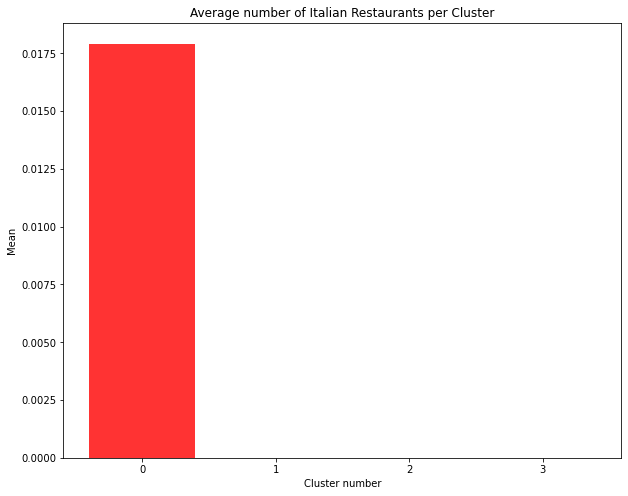

In [54]:
clusters_mean = [df_cluster0['Italian Restaurant'].mean(),df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean()]
objects = (0,1,2,3)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.figure(figsize=[10, 8])
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'blue','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster number')
plt.title('Average number of Italian Restaurants per Cluster')

plt.show()

In [57]:
clusters_mean 

[0.017922794117647058, 0.0, 0.0, 0.0]

## Results<a name="results"></a>

All of the Italian Restaurants are in cluster 0 represented by the red cluster. The Neighborhoods located in the North York area that have the highest average of Italian Restaurants are Bedford Park and Lawrence Manor East.  

Clusters 1 (blue) and 2 (aquamarine) with respectively 2 and 1 neighborhood are not good locations for a new Italian Restaurant.

Cluster 3 (darkkaki) with the second hugest amount of Neighborhoods and no Italian Restaurant seems to be a good location. As there is not Restaurant in Category Venue for this cluster it is not a good area for a new Italian Restaurant.    

Studio District in the borough of East Toronto in cluster 0 , with a low density of Italian Restaurant (0.027) and multiple restaurants from different cuisine seems to be the optimal location for a new Italian Restaurant.

## Discussion<a name="discussion"></a>

All of the above analysis is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.   

Final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighbourhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise and proximity to major roads, real estate availability, prices, social and economic dynamics of every neighbourhood etc.

## Conclusion<a name="conclusion"></a>

The purpose of this project was to identify Totonto areas with low number of restaurants (particularly Italian restaurants) to help  stakeholders in their search for optimal location for a new Italian restaurant.    

By calculating Italian Restaurants density distribution from Foursquare data, we have first identified general neighborhoods that justify further analysis (Bedford Park, Lawrence Manor East, St. James Town, Cabbagetown etc...). Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) as starting points for final exploration by stakeholders.